In [12]:
import pandas as pd
import numpy as np
from scipy import stats
import time
import csv
import os
import sys
import re
import itertools
from textwrap import wrap
from random import shuffle
import pickle
from IPython.display import display, Image
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
%matplotlib inline

######################## Learning ########################
# from sklearn_pandas import DataFrameMapper
# from sklearn.linear_model import LogisticRegression
# from sklearn.cluster import KMeans
# from sklearn import preprocessing

# import tensorflow as tf
# depreacted
# from tensorflow.models.rnn import rnn
# from tensorflow.models.rnn import rnn_cell

#################### Viz and plotting ####################

# from matplotlib.colors import LogNorm

# import plotly
# import plotly.plotly as py
# import plotly.graph_objs as go
# from plotly.tools import FigureFactory as FF

# from geopy.geocoders import Nominatim
# from pygeocoder import Geocoder

########################### SQL ##########################
# from sqlalchemy import create_engine
# from sqlalchemy.sql import text

########################### Text / Web Stuff ##########################

import urllib2
from bs4 import BeautifulSoup as bs
import wikipedia as wiki
import re
import pprint as pp

##### for reference #####
# import statsmodels.api as sm
# import pylab as pl
# from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Load data and preview
print ("Loading top songs data...")
top_songs = pd.read_csv("top_songs.csv")
print ("Data loaded successfully!")
print
print (top_songs.describe())

Loading top songs data...
Data loaded successfully!

              THEME       TITLE     ARTIST  YEAR  \
count           994         994        994   994   
unique            7         982        670   101   
top     Party songs  I Want You  Bob Dylan  1968   
freq            162           3         24    37   

                                              SPOTIFY_URL  
count                                                 772  
unique                                                767  
top     http://open.spotify.com/track/2Ei1sEtJU0ENRvk3...  
freq                                                    2  


# Explore the dataset

    - Histograms of themes, artists, years
    - themes over time

/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:545: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


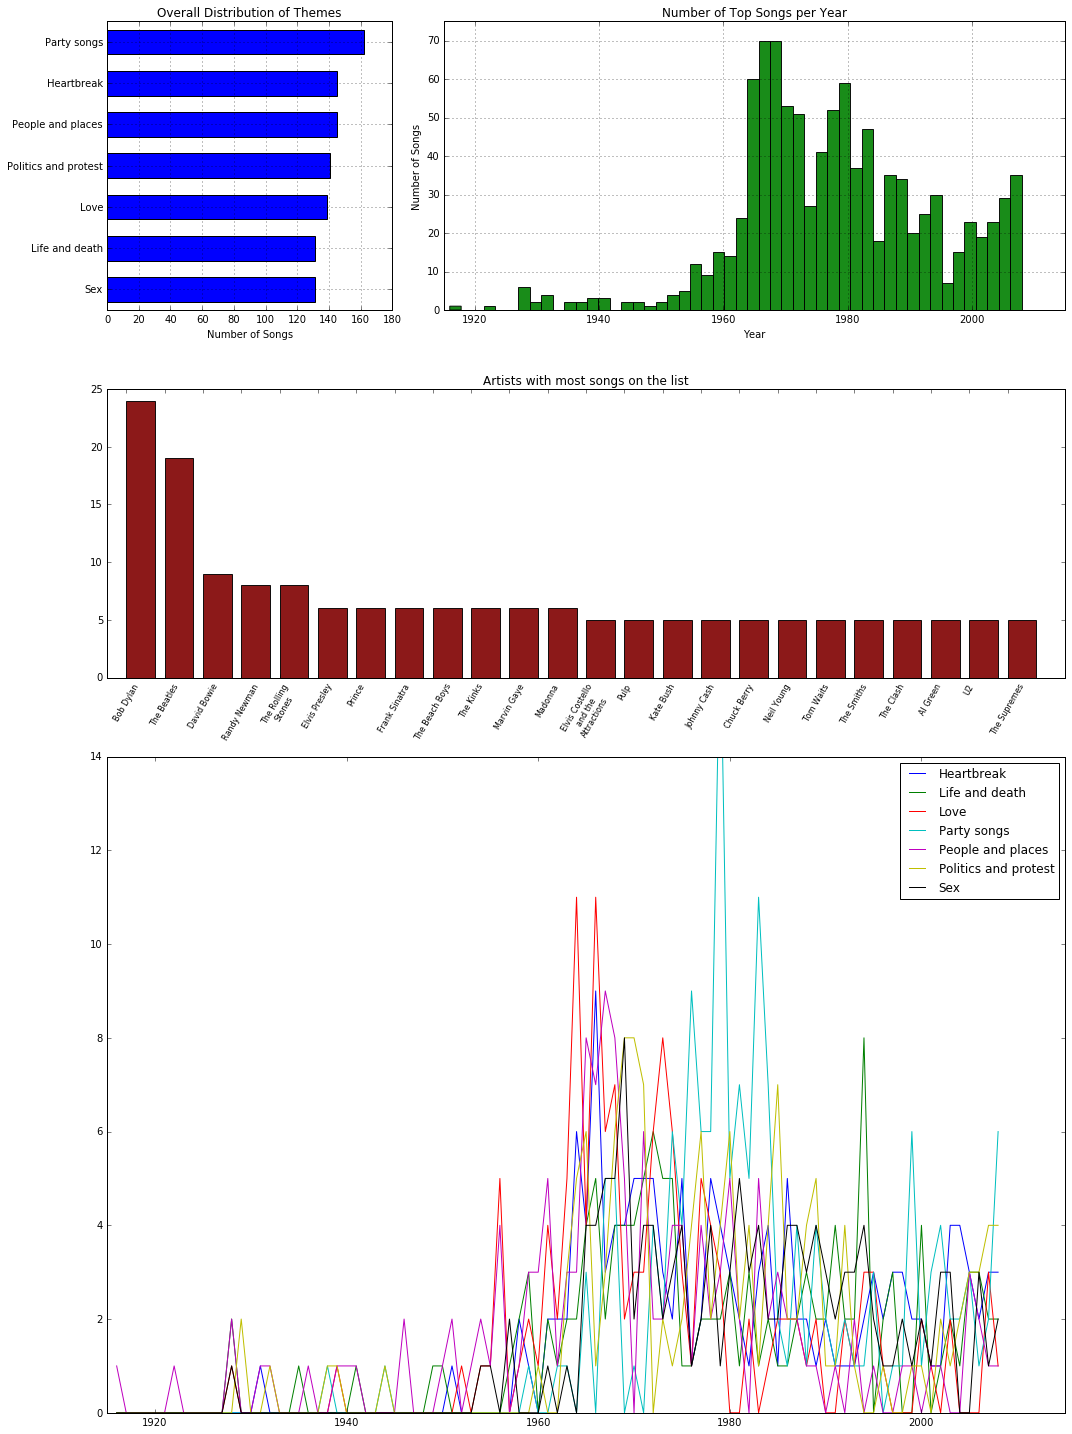

In [3]:
fig = plt.figure(figsize=(15,20))
fig_x = 4
fig_y = 3

# Theme counts
themes = top_songs['THEME'].unique()
theme_counts = top_songs['THEME'].value_counts().sort_values(axis=0, ascending=True)
# print (theme_counts)
themes_plot = fig.add_subplot(fig_x, fig_y, 1)
ind = (np.arange(len(theme_counts))) + .5
themes_plot.barh(left=0, width=theme_counts, height=0.6, bottom=ind,
                 tick_label=theme_counts.keys(), align='center')
themes_plot.set_title("Overall Distribution of Themes")
themes_plot.set_xlabel("Number of Songs")
themes_plot.grid(True)

# Artists Histogram
artists = top_songs['ARTIST'].unique()
artist_counts = top_songs['ARTIST'].value_counts()
a_cts = (artist_counts[:24])
artist_plot = fig.add_subplot(fig_x, fig_y, (4,6))
ind = (np.arange(len(a_cts))) + 0.5
labels = a_cts.keys()
labels = [ '\n'.join(wrap(l, 15)) for l in labels ]
artist_plot.bar(left=ind, width=0.75, height=a_cts, facecolor='maroon', alpha=0.9)
artist_plot.set_xticks(ind)
artist_plot.set_xticklabels(labels)
for label in artist_plot.get_xticklabels():
    label.set_rotation(60)
    label.set_fontsize(8)
artist_plot.set_title("Artists with most songs on the list")

# Songs per year
years_plot = fig.add_subplot(fig_x, fig_y, (2,3))
num_bins = 50
years = top_songs['YEAR']
l = [year.replace(',','') for year in years.tolist()]
years_data = map(int, map(float, l))
n, bins, patches = years_plot.hist(years_data, num_bins, facecolor='green', alpha=0.9)
years_plot.axis([1915, 2015, 0, 75])
years_plot.set_title('Number of Top Songs per Year')
years_plot.set_xlabel('Year')
years_plot.set_ylabel('Number of Songs')
years_plot.grid(True)

# Themes per year
tpy_plot = fig.add_subplot(fig_x, fig_y, (7, 12))
themes_year_subset = top_songs[['YEAR', 'THEME']]
themes_year_subset.loc[:,'YEAR'] = themes_year_subset.YEAR.apply(lambda x: int(float((x.replace(',','')))))
start = themes_year_subset['YEAR'].min()
stop = themes_year_subset['YEAR'].max()
blank_data = []
for year in range(start, stop):
    blank_data.append((year, 'to_delete'))
tempdf = pd.DataFrame(blank_data, columns=['YEAR', 'THEME'])
themes_year_subset = themes_year_subset.append(tempdf, ignore_index=True)
counts_per_year = pd.crosstab(themes_year_subset['YEAR'], themes_year_subset['THEME'])
counts_per_year = counts_per_year.drop('to_delete', axis=1)
temp_data = tpy_plot.plot(counts_per_year)
tpy_plot.axis([1915, 2015, 0, 14])
tpy_plot.legend(iter(temp_data), counts_per_year.columns.values)
    
plt.tight_layout()

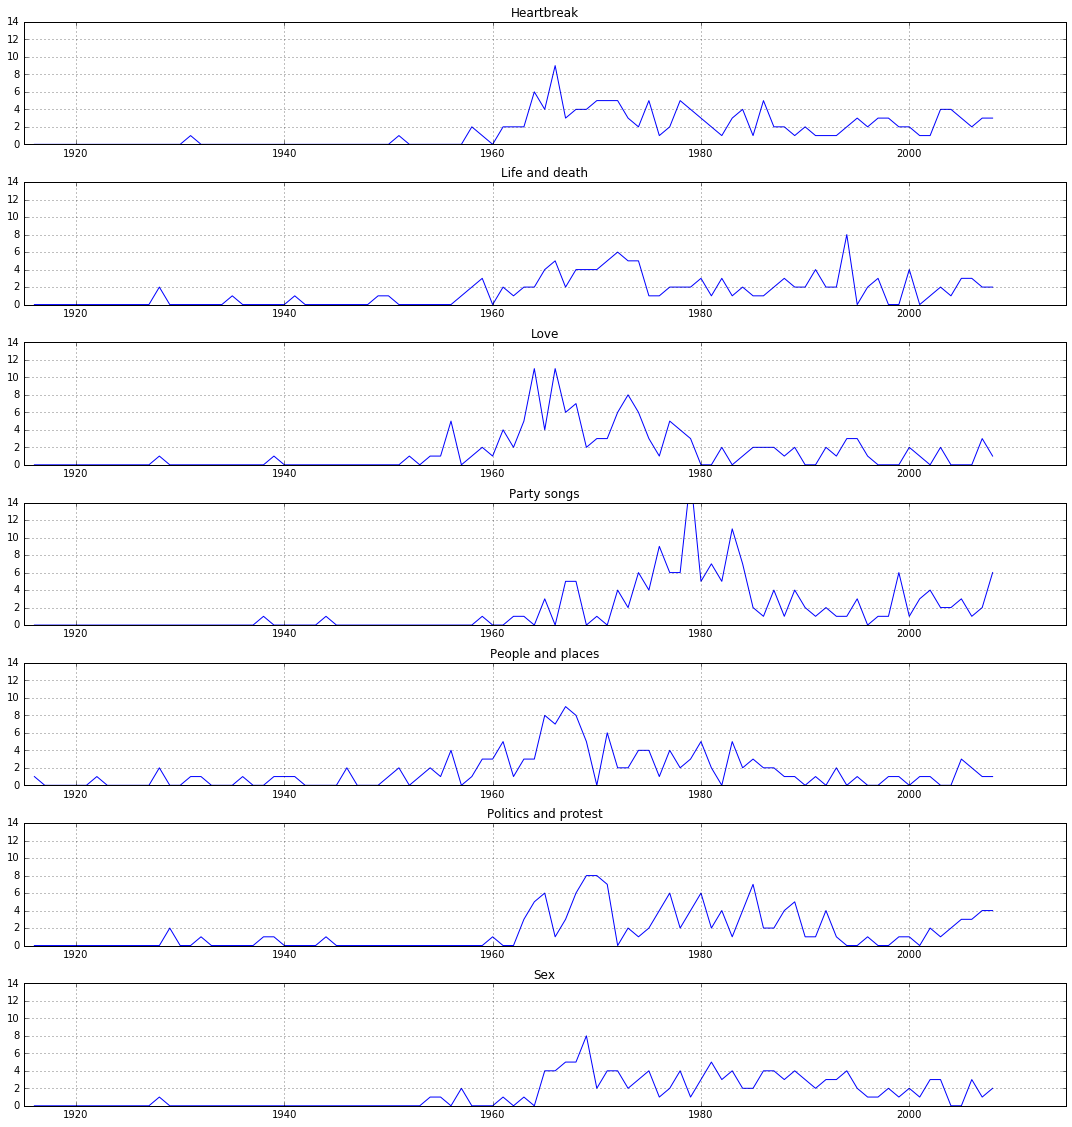

In [4]:
# Individual plots of themes per year
plt.close(fig)
fig = plt.figure(figsize=(15,20))
fig_x = 9
fig_y = 1

for theme, pos in zip(counts_per_year.columns.values, range(1, len(counts_per_year.columns.values)+1)):
    temp_plot = fig.add_subplot(fig_x, fig_y, (pos))
    output = temp_plot.plot(counts_per_year[theme])#, ls='steps')
    temp_plot.set_title(theme)
    temp_plot.axis([1915, 2015, 0, 14])
    temp_plot.grid(True)
    
plt.tight_layout()

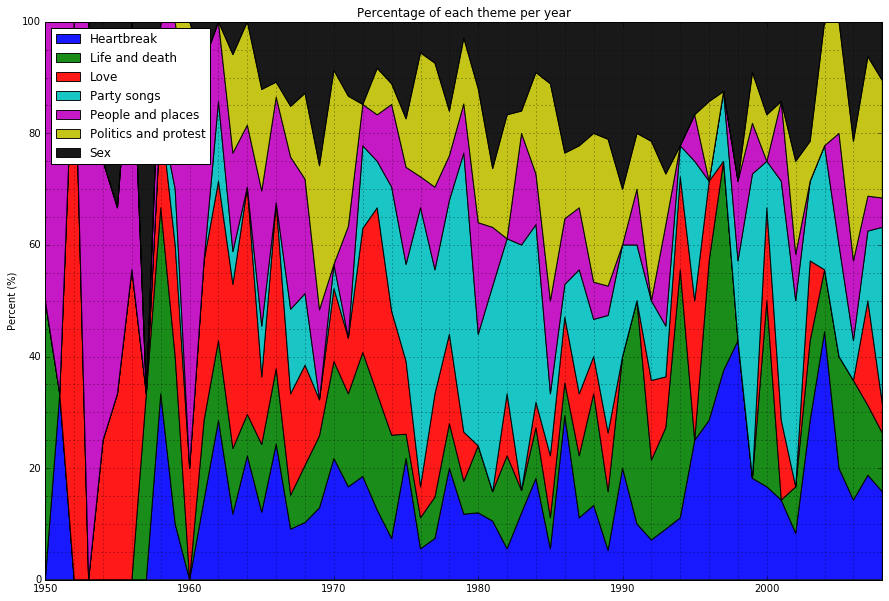

In [5]:
# Full stacked percentage plot
# each column must sum to 100, and have one for each period. x holds the periods
years = counts_per_year.index.values.tolist()
y_data = np.zeros(shape=[7,np.max(years)-np.min(years)+1])
for theme, row in zip(counts_per_year.columns.values, range(len(counts_per_year.columns.values))):
    y_data[row] = (counts_per_year[theme]).values
# print (y_data[0])
percent = y_data /  y_data.sum(axis=0).astype(float) * 100 
# print (percent[0])
percent = np.nan_to_num(percent)
# print (percent[0])

plt.close(fig)
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)

perct_plot = ax.stackplot(years, percent, alpha=0.9)
ax.set_title('Percentage of each theme per year')
ax.set_ylabel('Percent (%)')
ax.margins(0, 0) # Set margins to avoid "whitespace"
ax.legend(iter(perct_plot), counts_per_year.columns.values, loc=2)
ax.minorticks_on()
ax.grid(True, which='both')
ax.axis([1950, 2008, 0, 100])

plt.show()

DescribeResult(nobs=994, minmax=(2, 101), mean=17.423541247484909, variance=87.031912522466129, skewness=1.8078699616327498, kurtosis=7.9860503046797575)
Median: 16.0


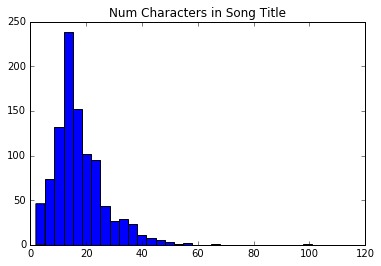

In [6]:
# Histogram of song title lengths
titles = top_songs['TITLE']
title_lengths = [len(x) for x in titles]
print (stats.describe(title_lengths))
print ("Median: {}".format(np.median(title_lengths)))
# print (title_lengths.index(101))
# print (titles[8], artists[8])

num_bins = 30
plt.hist(title_lengths, num_bins)
plt.title("Num Characters in Song Title")
plt.show()

The distribution looks continuous with a positive skew. This probably doesn't matter unless it's very different from the population (all songs). Interesting but maybe not relevant.

TO-DO:
    - nlp on song titles (most common words, themes, +/- etc.)
    - scrape lyrics, extra data (genre of music, other top songs, popularity), etc.

In [7]:
# Finds artist genres off wikipedia
#    This is cool, but, spotipy...

def get_artist_genres(artist_list):
    t0 = time.time()
    artist_dict = {}
    all_subs_list = []
    count = 0
    for artist in artist_list:
        artist_dict[artist] = []
        try:
            url = wiki.page(artist).url
            page = urllib2.urlopen(url)
            soup = bs(page)
            gen_list = soup.find(text='Genres').findNext('td')
            for sub in gen_list.findAll('a'):
                sub_txt = str(sub.text)
                artist_dict[artist].append(str(sub_txt).lower())
                if genre not in all_subs_list:
                    all_subs_list.append(sub_txt)
            count += 1
            page.close()
        except:
            print str(artist + " didn't work yo.")
            print (artist)
            print (url)
    print str("\n" + str(count) + " artists' genres successfully added in just {:.4}s!".format(time.time() - t0))
    print ('\n')
    return artist_dict, all_subs_list

thing = top_songs['ARTIST'].sort_values().unique()[:50]
print (thing)
artist_sub_dict, all_subs = get_artist_genres(thing)
print ("\n\nList of all sub-genres:\n")
print (all_subs)
for key in artist_sub_dict.keys():
    print ("\n{}'s sub-genres:".format(key))
    print (artist_sub_dict[key])

['!!!' '808 State' 'A R Rahman' 'ABC' 'AC/DC' 'ATB' 'Aaliyah' 'Abba'
 'Abyssinians' 'Aerosmith' 'Afroman' 'Al Green' 'Alice Cooper'
 'Alicia Keys' 'Aliotta Haynes Jeremiah' 'All Saints' 'Althea and Donna'
 'Amy Winehouse' 'Andy Williams' 'Ann Peebles' 'Anne Briggs'
 'Anthony Johnson' 'Antony and the Johnsons' 'Aphex Twin' 'Arcade Fire'
 'Archie Bell and the Drells' 'Archie Bleyer' 'Arctic Monkeys'
 'Aretha Franklin' 'Arthur Conley' 'Arthur Russell' 'Artie Shaw'
 'Ashford and Simpson' 'Astrud Gilberto' 'Au Pairs' 'BB King' 'Baccara'
 'Badfinger' 'Badly Drawn Boy' 'Baggy Trousers' 'Bappi Lahiri/Parvati Khan'
 'Barbra Streisand and Barry\xe5\xcaGibb' 'Barrington Levy' 'Barry McGuire'
 'Beastie Boys' 'Bee Gees' 'Belle and Sebastian' 'Ben E King'
 'Benga and Coki' 'Bessie Smith']


/anaconda/lib/python2.7/site-packages/bs4/__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


!!! didn't work yo.
!!!
https://en.wikipedia.org/wiki/!!!
808 State didn't work yo.
808 State
https://en.wikipedia.org/wiki/808_State
A R Rahman didn't work yo.
A R Rahman
https://en.wikipedia.org/wiki/A._R._Rahman
ABC didn't work yo.
ABC
https://en.wikipedia.org/wiki/A._R._Rahman
AC/DC didn't work yo.
AC/DC
https://en.wikipedia.org/wiki/AC/DC
ATB didn't work yo.
ATB
https://en.wikipedia.org/wiki/ATB
Aaliyah didn't work yo.
Aaliyah
https://en.wikipedia.org/wiki/Aaliyah
Abba didn't work yo.
Abba
https://en.wikipedia.org/wiki/ABBA
Abyssinians didn't work yo.
Abyssinians
https://en.wikipedia.org/wiki/ABBA
Aerosmith didn't work yo.
Aerosmith
https://en.wikipedia.org/wiki/Aerosmith
Afroman didn't work yo.
Afroman
https://en.wikipedia.org/wiki/Afroman
Al Green didn't work yo.
Al Green
https://en.wikipedia.org/wiki/Al_Green
Alice Cooper didn't work yo.
Alice Cooper
https://en.wikipedia.org/wiki/Alice_Cooper
Alicia Keys didn't work yo.
Alicia Keys
https://en.wikipedia.org/wiki/Alicia_Keys
Alio

In [9]:
def get_genres_and_subs_wiki():
    genre_dict = {}
    url = wiki.page("Category:Musical_subgenres_by_genre").url
    page = urllib2.urlopen(url)
    soup = bs(page)
    selection = soup.findAll("div", { "class" : "CategoryTreeSection" })
    for item in selection:
        genre_tag = item.findNext('a')
        genre = (genre_tag.text)
        if genre[-7:] == ' genres':
            genre = str(genre[:-7])
#         print (genre)
        genre_dict[(genre)] = []
        genre_link = (genre_tag.get('href'))[6:]
#         print (genre_link)
        genre_page = urllib2.urlopen(wiki.page(genre_link).url)
        genre_soup = bs(genre_page)
        genre_selection = genre_soup.findAll("div", {"class": "mw-content-ltr"})[-1]
        lists_of_subs = genre_selection.findAll('li')
        for sub in lists_of_subs:
#             print (sub.text)
            sub_str = str(sub.text.encode('ascii', 'ignore')).lower()
            if sub_str[:7] != 'List of':
                genre_dict[genre].append(sub_str)
            else:
#                 print ("{}...really?".format(sub_str))
                pass    
        genre_page.close()
    page.close()
    return genre_dict

genre_with_subs = get_genres_and_subs_wiki()
for key in genre_with_subs.keys():
    print ("{} sub-genres:".format(key))
    print (genre_with_subs[key])

Alternative rock sub-genres:
['alternative dance', 'alternative metal', 'b-town', 'baggy', 'britpop', 'chamber pop', 'christian alternative rock', 'college rock', 'dark cabaret', 'dark rock', 'dream pop', 'dunedin sound', 'emo', 'ethereal wave', 'gothabilly', 'gothic rock', 'grebo music', 'grunge', 'indie folk', 'industrial rock', 'italian occult psychedelia', 'jangle pop', 'latin alternative', 'lo-fi music', 'madchester', 'math rock', 'neo-psychedelia', 'noise pop', 'noise rock', 'nu metal', 'pagan rock', 'paisley underground', 'post-britpop', 'post-grunge', 'post-punk revival', 'post-rock', 'pyramid (providence band)', 'riot grrrl', 'sadcore', 'slowcore', 'time lord rock']
Trance sub-genres:
['list of trance genres', 'acid trance', 'dream trance', 'electrowavez', 'hard trance', 'hardstyle', 'lento violento', 'list of progressive house artists', 'list of vocal trance artists', 'progressive house', 'psychedelic trance', 'rebolation', 'suntrip records', 'tech trance', 'uplifting trance'

In [15]:
# pp.pprint(genre_with_subs)

# save the subgenre dict to a pickle
with open('sub_genre_dict' + '.pkl', 'wb') as f:
        pickle.dump(genre_with_subs, f, pickle.HIGHEST_PROTOCOL)